# Train Convolutional Neural Network

Before applying Convolutional models, I started with 2 versions of linear classifier (more in `train_linear_classifier.ipynb`) and then moved to simple Fully Connected neural networks (MLP) (more in `train_fcc_nn.ipynb`). 

Up to this moment, the best classification result that I got was `0.8767` accuracy during cross-validation. So I believe that CNN will help me to reach higher values.

## Import modules

In [97]:
import math
import pickle
import sys
sys.path.append('..')

import matplotlib.pyplot as plt
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms

from config import path_to_mean_image
from modules.load_data import load_data
from modules.train_functions import check_accuracy, plot_accs_and_loss, train_nn, cross_validation_score

%matplotlib inline
plt.rcParams['figure.figsize'] = (16.0, 12.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

path_to_root = '../'
path_to_mean_image = path_to_root + path_to_mean_image

## Load images and apply transformations

Based on cross-validation I chose following transformations:
* `Grayscale`, that converts a RGB-image to grayscale.
* `Resize`, because all input images have different shapes. Before I resized to [84 x 64], but I think it's more convenient for convolutional layers to have squared images. That's why I resized to [64 x 64].
* `ColorJitter`, that randomly changes brightness, contrast and saturation of an image. 
* `RandomHorizontalFlip`, that horizontally flip an image.

In [5]:
spatial_shape = 64
height, width = 84, 64

train_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((spatial_shape, spatial_shape)),
    transforms.ColorJitter(),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transforms = transforms.Compose([
    transforms.Grayscale(),
    transforms.Resize((spatial_shape, spatial_shape)),
    transforms.ColorJitter(),
    transforms.ToTensor(),
])


X_train, y_train = load_data(path_to_root + 'train_data', train_transforms, path_to_mean_image)
X_val, y_val = load_data(path_to_root + 'val_data', train_transforms, path_to_mean_image)
X_hold, y_hold = load_data(path_to_root + 'hold_data', test_transforms, path_to_mean_image)

print(f'X_train has {X_train.shape[0]} samples')
print(f'X_val has {X_val.shape[0]} samples')
print(f'X_hold has {X_hold.shape[0]} samples')

X_train has 15000 samples
X_val has 3000 samples
X_hold has 10000 samples


## Implementation of CNN

From cs231n class I remember that build a custom achitecture is not a good idea and it is more better to use any existing proven architecture. 

But I have 2 reasons why I decided to use custom achitecture:
1. Data were loaded on Google Colab in a very-very slow way, so I forced to use only my laptop's cpu, and computational resources were too little.
2. Cool architectures, that I knew about, were designed for more complex problems (for example, for ImageNet competition, where data has 1000 classes), but for this task with only 2 classes I think it will be overkill. Unfortunately, I have learned about lightweight architectures like *MobileNet* and *ShuffleNet* only few hours before the deadline so I can't be in time with it, but I want to try it later to compare with my frankenstein :)

And I wanted to do this for practice. So below is the simple version of convolutional nn.

This implementation of CNN is highly-reduced version of *VGG*. From it I took following base rules: 
* 3x3 convolutions
* max pooling after 2 convolutions
* all convolutions have stride = 1, padding = 1
* all max pooling have stride = 2
* number of channels doubled on every second layer
* activation function is ReLU

In [6]:
class ConvolutionalNN(nn.Module):
    ''' 
    Convolutional Neural Network with 9 layers 
    
    Layer 1:
    - 3x3 Conv C_in = 1, C_out = 16
    - Batch Normalization, ReLU
    
    Layer 2:
    - 3x3 Conv C_in = 16, C_out = 16
    - Batch Normalization, ReLU
    - 2x2 MaxPool 

    Layer 3:
    - 3x3 Conv C_in = 16, C_out = 32
    - Batch Normalization, ReLU
    
    Layer 4:
    - 3x3 Conv C_in = 32, C_out = 32
    - Batch Normalization, ReLU
    - 2x2 MaxPool 

    Layer 5:
    - 3x3 Conv C_in = 32, C_out = 64
    - Batch Normalization, ReLU
    - 2x2 MaxPool

    Layer 6:
    - 3x3 Conv C_in = 64, C_out = 64
    - Batch Normalization, ReLU
    - 2x2 MaxPool

    Layer 7:
    - Linear D_in = 64 * 4 * 4, D_out = 512; + ReLU

    Layer 8:
    - Linear D_in = 512, D_out = 64; + ReLU

    Layer 9:
    - Linear D_in = 64, D_out = 1; + Sigmoid

    All convolutions have stride = 1, padding = 1
    and all MaxPools have stride = 2
    '''
    def __init__(self):
        super(ConvolutionalNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Conv2d(16, 16, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 32 x 32
        
        self.layer2 = nn.Sequential(
            nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 32, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 16 x 16
        
        self.layer3 = nn.Sequential(
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 8 x 8
        
        self.layer4 = nn.Sequential(
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)) # 4 x 4
        
        self.fc1 = nn.Linear(64 * 4 * 4, 512)
        self.fc2 = nn.Linear(512, 64)
        self.fc3 = nn.Linear(64, 1)


    def forward(self, x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = out.view(out.shape[0], -1)
        out = F.relu(self.fc1(out))
        out = F.relu(self.fc2(out))
        out = self.fc3(out)
        out = torch.sigmoid(out)
        return out

## Cross-validation

Fold 1 ->
Start training
Epoch [1/10] it 76: loss 0.5122759820599305 - train acc 0.8703703880310059 - val acc 0.8345511555671692
Epoch [2/10] it 76: loss 0.2586695878325324 - train acc 0.9334897994995117 - val acc 0.9029227495193481
Epoch [3/10] it 76: loss 0.1597093372654758 - train acc 0.9548774361610413 - val acc 0.9112734794616699
Epoch [4/10] it 76: loss 0.1283970900909289 - train acc 0.9507042169570923 - val acc 0.8987473845481873
Epoch [5/10] it 76: loss 0.10048153362923155 - train acc 0.9739176034927368 - val acc 0.9102296233177185
Epoch [6/10] it 76: loss 0.08871572017424594 - train acc 0.9830464124679565 - val acc 0.9227557182312012
Epoch [7/10] it 76: loss 0.07214161117659196 - train acc 0.9853938221931458 - val acc 0.918058454990387
Epoch [8/10] it 76: loss 0.042616934935243704 - train acc 0.9880020618438721 - val acc 0.9154488444328308
Epoch [9/10] it 76: loss 0.058404062831725334 - train acc 0.9817423224449158 - val acc 0.9024008512496948
Epoch [10/10] it 76: loss 0.02898

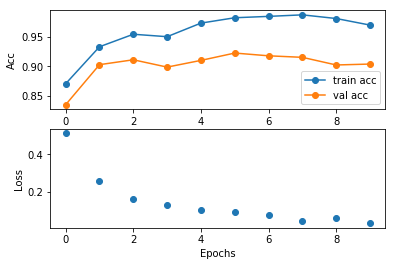

Fold 2 ->
Start training
Epoch [1/10] it 76: loss 0.41623455148778465 - train acc 0.8638497591018677 - val acc 0.8272442817687988
Epoch [2/10] it 76: loss 0.19761469509256513 - train acc 0.9368805289268494 - val acc 0.9013569951057434
Epoch [3/10] it 76: loss 0.14275602849298402 - train acc 0.9465310573577881 - val acc 0.8898747563362122
Epoch [4/10] it 76: loss 0.1144022677632931 - train acc 0.9733959436416626 - val acc 0.9274530410766602
Epoch [5/10] it 76: loss 0.08856302406638861 - train acc 0.9611371755599976 - val acc 0.8971816301345825
Epoch [6/10] it 76: loss 0.09062514585246773 - train acc 0.9739176034927368 - val acc 0.9112734794616699
Epoch [7/10] it 76: loss 0.060432539272465204 - train acc 0.9436619877815247 - val acc 0.862734854221344
Epoch [8/10] it 76: loss 0.05888564640496809 - train acc 0.9866979718208313 - val acc 0.9264091849327087
Epoch [9/10] it 76: loss 0.040238634019930795 - train acc 0.9843505620956421 - val acc 0.9232776761054993
Epoch [10/10] it 76: loss 0.03

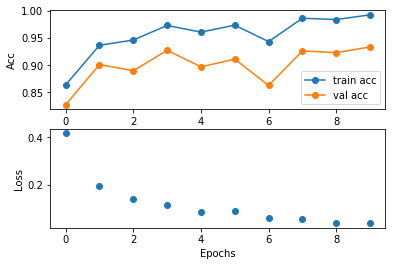

Fold 3 ->
Start training
Epoch [1/10] it 76: loss 0.4975371305879794 - train acc 0.8898747563362122 - val acc 0.882567822933197
Epoch [2/10] it 76: loss 0.2634142602940923 - train acc 0.905010461807251 - val acc 0.8789144158363342
Epoch [3/10] it 76: loss 0.17983486189654 - train acc 0.9266701340675354 - val acc 0.8971816301345825
Epoch [4/10] it 76: loss 0.14027341964997744 - train acc 0.9585072994232178 - val acc 0.9211899638175964
Epoch [5/10] it 76: loss 0.1139889383982671 - train acc 0.9710333943367004 - val acc 0.9243215322494507
Epoch [6/10] it 76: loss 0.07321793712234419 - train acc 0.9791231751441956 - val acc 0.9232776761054993
Epoch [7/10] it 76: loss 0.07599339755497088 - train acc 0.9848642945289612 - val acc 0.9243215322494507
Epoch [8/10] it 76: loss 0.05463240972082866 - train acc 0.9885177612304688 - val acc 0.9258872866630554
Epoch [9/10] it 76: loss 0.05399745837540219 - train acc 0.980167031288147 - val acc 0.9144049882888794
Epoch [10/10] it 76: loss 0.04594581073

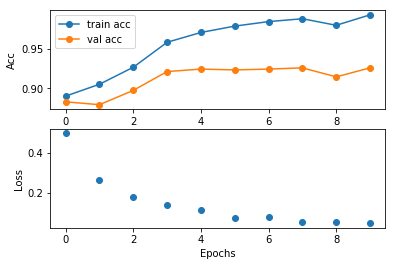

0.9274530212084452
0.004609476432183767
CPU times: user 48min 40s, sys: 6min 41s, total: 55min 21s
Wall time: 34min 37s


In [122]:
%%time
torch.manual_seed(777)
val_results = cross_validation_score(X_train, y_train, num_epochs=10, batch_size=50, num_folds=3)
print(np.mean(val_results))
print(np.std(val_results))

## Create and train model with selected hyperparameters

In [14]:
net = ConvolutionalNN()
if torch.cuda.is_available():
    net = net.cuda()

criterion = nn.BCELoss()
optimizer = optim.Adam(net.parameters(), lr=1e-3, betas=(0.9, 0.999))

train_parameters = {
    'model': net,
    'criterion': criterion,
    'optimizer': optimizer
}

In [15]:
%%time
torch.manual_seed(777)

results, best_val = train_nn(train_parameters, X_train, y_train, X_val, y_val, 
                             num_epochs=10, checkpoint_filename=path_to_root + 'models/cnn_9layers.pth')

Start training
Epoch [1/10] it 300: loss 0.28488325657943886 - train acc 0.9291333556175232 - val acc 0.9326666593551636
Epoch [2/10] it 300: loss 0.17120098202799758 - train acc 0.9443333148956299 - val acc 0.940666675567627
Epoch [3/10] it 300: loss 0.12598777956639726 - train acc 0.9629999995231628 - val acc 0.9536666870117188
Epoch [4/10] it 300: loss 0.09856397469217579 - train acc 0.9461333155632019 - val acc 0.9276666641235352
Epoch [5/10] it 300: loss 0.08726606130599976 - train acc 0.9592000246047974 - val acc 0.9383333325386047
Epoch [6/10] it 300: loss 0.0689381350359569 - train acc 0.9847333431243896 - val acc 0.956333339214325
Epoch [7/10] it 300: loss 0.05926984831768398 - train acc 0.9808666706085205 - val acc 0.9599999785423279
Epoch [8/10] it 300: loss 0.05102394178121661 - train acc 0.9849333167076111 - val acc 0.9610000252723694
Epoch [9/10] it 300: loss 0.04293642190876805 - train acc 0.9885333180427551 - val acc 0.9620000123977661
Epoch [10/10] it 300: loss 0.03251

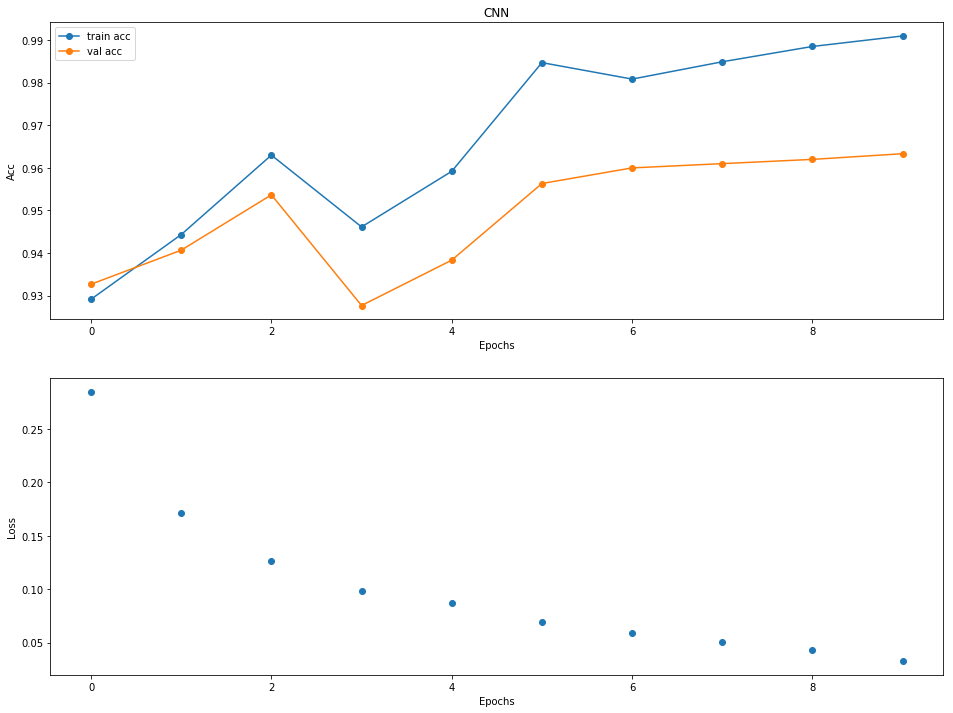

In [16]:
plot_accs_and_loss(results, 'CNN')

## Load the best model and try it on the hold data

In [18]:
best_cnn = ConvolutionalNN()
best_cnn.load_state_dict(torch.load(path_to_root + 'models/cnn_9layers.pth'))

<All keys matched successfully>

In [19]:
%%time
check_accuracy(best_cnn, X_hold, y_hold)

CPU times: user 42.1 s, sys: 31.6 s, total: 1min 13s
Wall time: 1min 22s


0.9531999826431274

## Analyze model's mistakes

In [95]:
rand_indices = torch.randint(0, X_hold.shape[0], (100, ))
X_batch = X_hold[rand_indices]
y_batch = y_hold[rand_indices]

out = best_cnn(X_batch)
out = (out.flatten() > 0.5).float()

X_mistaked = X_batch[y_batch != out]
true_labels = y_batch[y_batch != out]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


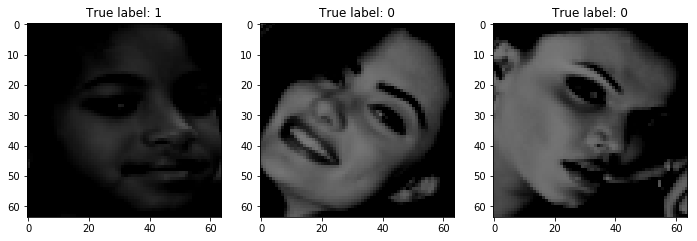

In [96]:
fig = plt.figure()
# fig.subplots_adjust(wspace=0.25, hspace=0.0)
for i in range(X_mistaked.shape[0]):
    ax = fig.add_subplot(2, 4, i + 1)
    image = torch.stack([X_mistaked[i][0]] * 3).permute(1, 2, 0)
    image - image.max() / (image.min() - image.max())
    ax.imshow(image)
    plt.title('True label: ' + str(true_labels[i].item()))

After running cells for mistakes' analyzing many times, I understood that model doesn't work well with:
* images with bend of a head (like above)
* images with people wearing glasses or sunglasses
* images with elder people

It leads to the conclusion that I should choose more images to the train dataset, apply transformations with horizontal flip and try more augmentation techniques.

## Conclusion:
It is no wonder that convolutional models have better perfomance, so this case is an another evidence. 

The best result during cross-validation is `0.9275`. And the model trained again with selected hyperparameters and more training epochs reached `0.9532` on hold (unseen) data. This model will be used for remaining tasks.